In [1]:
import ugradio
import ugradio.coord
import astropy.coordinates
import astropy.time
import time
import numpy as np
import matplotlib.pylab as plt
import inspect
import collections
from scipy.interpolate import interp1d
# import emcee

In [2]:
samp_freq = 500 * 1000 * 1000 # Hz

fname = f'../combined_data/sun/full_day_sun_740am.npy'
data = np.load(fname, allow_pickle=True).tolist()
all_data = {}
for k in data[0].keys():
    all_data[k] = [d.get(k) for d in data]

In [3]:
total_duration = (data[-1]['time']-data[0]['time'])/60
print(total_duration)

438.8556294997533


In [4]:
print(str((all_data['time'][-1] - all_data['time'][0])/60) + ' min')

438.8556294997533 min


In [5]:
def fft(data, num_samp=1024, samp_rate=samp_freq):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

In [6]:
def t1():
    raw_data = np.array([dictionary['corr01'] for dictionary in data])
    result = []
    for point in raw_data:
        f, Fx = fft(point)
        plt.plot(f * 10**-9, np.abs(Fx)**2)
        result += [f[np.argwhere(Fx == np.max(Fx))]]
        # break
    plt.xlabel('Time Delay [nanosec]')
    plt.ylabel('Power')
    # plt.xlim(-.004,.004)
    plt.title('Single Block Power Spectrum')

# data

In [7]:
visibility = all_data['corr01'] - np.mean(all_data['corr01'], axis=0, keepdims=True)
freqs = np.fft.fftshift(np.fft.fftfreq(1024, 1/500)) + 1540
visibility = visibility[:, 400:900]
times = np.array(all_data['time'])
C = 299792458 # m/s
LO = 8.75e9 + 1.54e9
freqs = np.linspace(0, 250e6, 1024, endpoint=False) + LO
freqs = freqs[400:900]

visibility.shape

(21020, 500)

# Visibility

Text(0, 0.5, 'Observations')

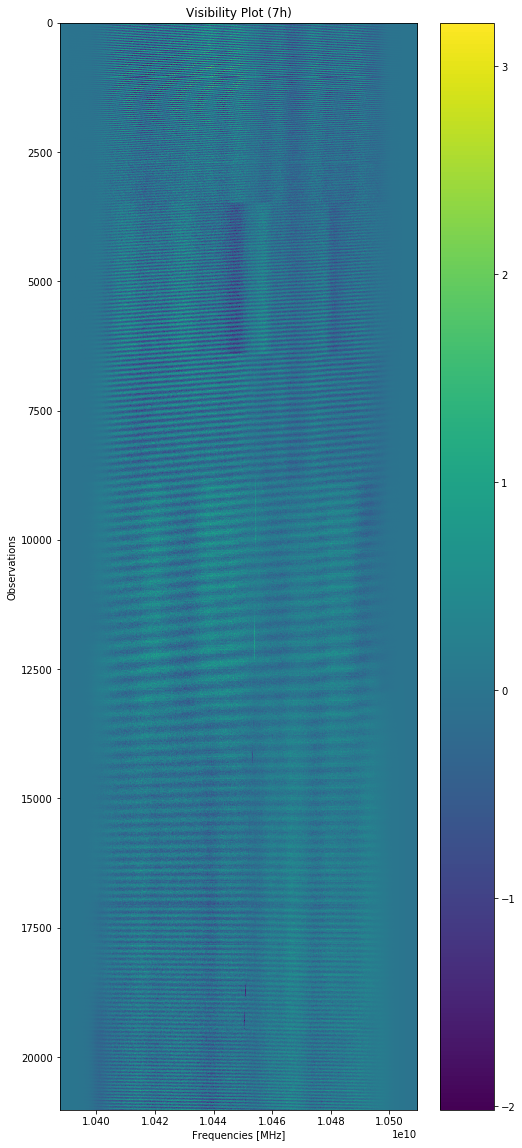

In [8]:
plt.figure(figsize=(8,20))
plt.imshow(visibility.real, aspect='auto', extent=[freqs[0], freqs[-1], len(visibility), 0])
plt.colorbar()
plt.title('Visibility Plot (7h)')
plt.xlabel('Frequencies [MHz]')
plt.ylabel('Observations')
# plt.xlim(1500, 1700)
# plt.ylim(12500, 12000)

# angle plot?

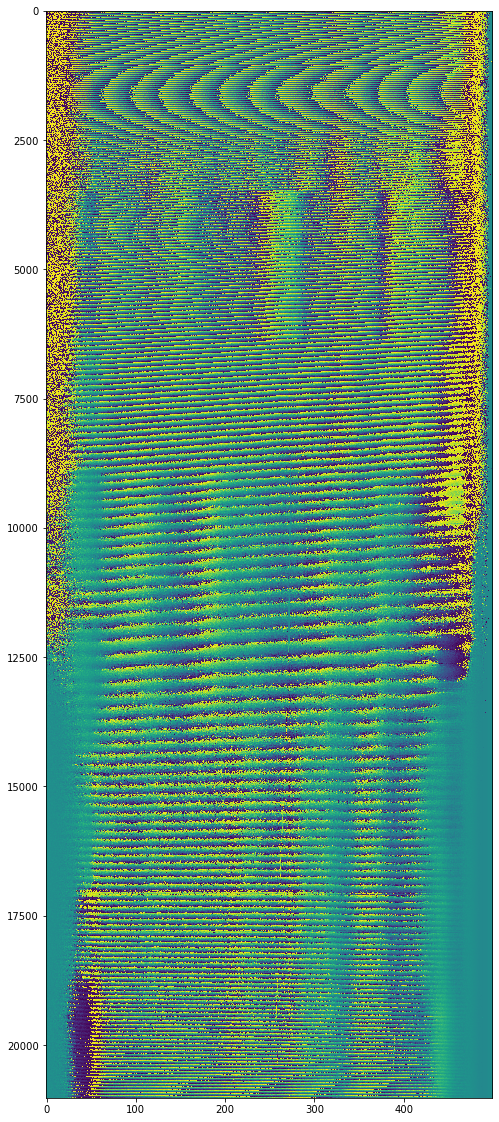

In [9]:
plt.figure(figsize=(8,20))
plt.imshow(np.angle(visibility), interpolation='nearest', aspect='auto')

# fft of the data

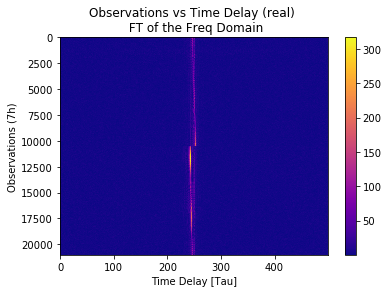

In [10]:
ftfreq = np.fft.fftshift(np.fft.fft(visibility, axis=1))
ffreq2 = np.fft.fft(all_data['corr01'], axis=1)

plt.figure()
plt.imshow(np.abs(ftfreq), aspect='auto', cmap='plasma')
plt.xlabel('Time Delay [Tau]')
plt.ylabel('Observations (7h)')
plt.title('Observations vs Time Delay (real) \n FT of the Freq Domain')
plt.colorbar()
# plt.xlim(450, 550)
# plt.ylim(12500, 10000)
plt.show()

# NOT airy ring
airy ring = ring of the sun

fft2 of the data


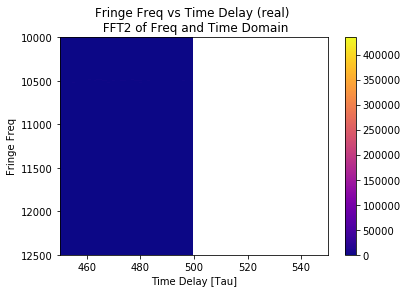

In [11]:
ftfreq = np.fft.fftshift(np.fft.fft2(visibility))
ffreq2 = np.fft.fft(all_data['corr01'], axis=1)

plt.figure()
plt.imshow(np.abs(ftfreq), aspect='auto', cmap='plasma')
plt.xlabel('Time Delay [Tau]')
plt.ylabel('Fringe Freq')
plt.title('Fringe Freq vs Time Delay (real) \n FFT2 of Freq and Time Domain')
plt.colorbar()
plt.xlim(450, 550)
plt.ylim(12500, 10000)
plt.show()

# something

plotting the power (after FT) of a given freq slice

what r the x and y axes?

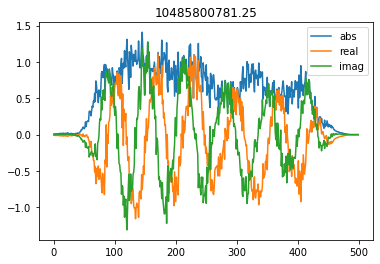

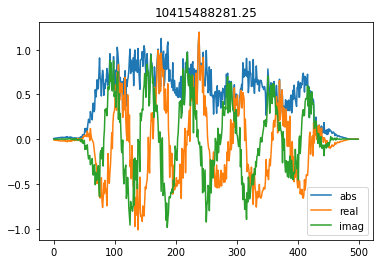

In [12]:
# attempt to create the sin func on the board in a single freq channel

def plot2():
    result = []
    for f in sorted(np.random.choice(freqs, size=1)):
        Y = visibility[np.argwhere(freqs <= f)[-1, 0]]
        result = np.append(result, Y)
        plt.title(f'{str(f)}')
        plt.plot(np.abs(Y), label=f'abs')
        plt.plot(Y.real, label=f'real')
        plt.plot(Y.imag, label=f'imag')
    # plt.xlim(400, 850) 
    plt.legend()
    plt.show()
    return result
_ = plot2()
_ = plot2()

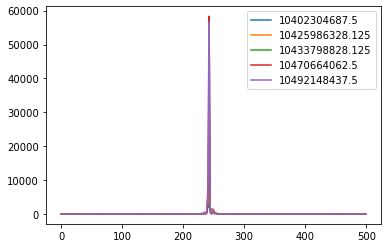

In [13]:
def plot1():
    result = []
    for f in sorted(np.random.choice(freqs, 5)):
        Fx = np.fft.fftshift(np.fft.fft(visibility[np.argwhere(freqs <= f)[-1][0]]))
        result = np.append(result, Fx)
        plt.plot(np.abs(Fx)**2, label=str(f))
        # break
    plt.legend()
    return result
_ = plot1()

# fitting

In [14]:
# custom rotation matrices


print(times.shape)
jds_data = ugradio.timing.julian_date(times)

def get_rot_full():
    lst0 = ugradio.timing.lst(jds_data[0])
    lst1 = ugradio.timing.lst(jds_data[1])
    lsts = lst0 + np.arange(jds_data.shape[0]) * (lst1 - lst0)
    ones = np.ones_like(lsts)
    #ha = lsts - radec[0]
    rot_eq_ha = np.array([[
        [np.cos(lsts),  np.sin(lsts),     0*ones],
        [np.sin(lsts), -np.cos(lsts),     0*ones],
        [      0*ones,        0*ones,     1*ones],
    ]])
    lat = np.deg2rad(ugradio.nch.lat)
    rot_ha_altaz = np.array([[
        [-np.sin(lat),  0, np.cos(lat)],
        [           0, -1,           0],
        [ np.cos(lat),  0, np.sin(lat)],
    ]])

    rot_full = np.dot(rot_ha_altaz, rot_eq_ha)
    rot_full.shape = (3, 3, -1)
    return rot_full
get_rot_full()

(21020,)


array([[[-0.11918612, -0.11920302, -0.11921993, ..., -0.43403   ,
         -0.43404218, -0.43405437],
        [ 0.60223547,  0.60223212,  0.60222877, ...,  0.43417836,
          0.43416618,  0.434154  ],
        [ 0.78937134,  0.78937134,  0.78937134, ...,  0.78937134,
          0.78937134,  0.78937134]],

       [[ 0.98097368,  0.98096823,  0.98096278, ...,  0.70722761,
          0.70720776,  0.70718792],
        [ 0.19414076,  0.19416829,  0.19419582, ...,  0.70698594,
          0.70700578,  0.70702563],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.15324915,  0.15327088,  0.15329261, ...,  0.55807444,
          0.5580901 ,  0.55810577],
        [-0.77435251, -0.77434821, -0.77434391, ..., -0.5582652 ,
         -0.55824954, -0.55823388],
        [ 0.61391603,  0.61391603,  0.61391603, ...,  0.61391603,
          0.61391603,  0.61391603]]])

In [15]:
# acquiring sun positons for recorded times

def get_sun_pos_top():

    sun_radec = ugradio.coord.sunpos(jds_data[0])
    radec = (np.deg2rad(sun_radec[0]), np.deg2rad(sun_radec[1]))
    theta = np.pi/2 - radec[1]
    phi = radec[0]
    sun_z = np.cos(theta)
    r_xy = np.sin(theta)
    sun_x = r_xy * np.cos(phi)
    sun_y = r_xy * np.sin(phi)
    sun_pos_eq = np.array([sun_x, sun_y, sun_z])
    sun_pos_top = np.dot(sun_pos_eq, get_rot_full())
    # print(sun_pos_top.shape)
    sun_pos_top = np.array([sun_pos_top[1], sun_pos_top[0], sun_pos_top[2]])
    # print(sun_pos_top.shape)
    return sun_pos_top

sun_pos_top = get_sun_pos_top()
    

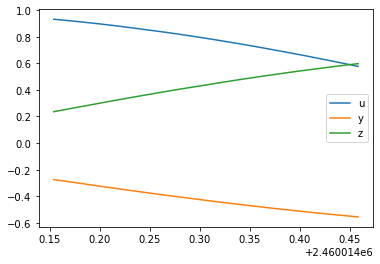

In [16]:
plt.figure()
plt.plot(jds_data, sun_pos_top[0], label='u')
plt.plot(jds_data, sun_pos_top[1], label ='y')
plt.plot(jds_data, sun_pos_top[2], label ='z')
plt.legend()

In [25]:
# generating fringe

def baseline(u, y, z):
    return np.array([u, y, z])

def get_fringe(baseline, freq=200):
    fq = freqs[freq] 
    b_proj = np.dot(baseline, sun_pos_top)
    lam = C / fq
    w = b_proj / lam
    fringe = np.exp(-2*np.pi*1j*w)
    fringe = np.where(sun_pos_top[2] > 0, fringe, 0)
    return fringe


/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 1000)

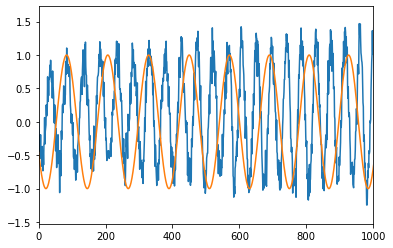

In [18]:
f = 200

plt.figure()
plt.plot(visibility[:,f])
plt.plot(get_fringe(baseline(20., 2, 0), freq=f.real))
plt.xlim(0,1000)

use emcee package
monte carlo markov chains 

In [19]:
from scipy.optimize import minimize

def obj_func(baseline, freq_i, min_i, max_i):
    Y = visibility[min_i:max_i, freq_i]
    fringe = get_fringe(baseline, freq_i)[min_i:max_i]
    return np.mean((Y - fringe)**2)

result = minimize(fun=obj_func, x0=baseline(20., 2, 0), args=(200, 0, 5000));
print(f'baseline estimate: {result.x} meters')

/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/lib/python3/dist-packages/scipy/optimize/linesearch.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


baseline estimate: [ 19.80503384 -11.13111175 -10.28845874] meters


In [20]:
result

      fun: -0.02862831040514316
 hess_inv: array([[   788.58972156,   9159.70481963,   7580.26783698],
       [  9159.70482127, 106402.80533521,  88058.03952838],
       [  7580.26783926,  88058.03953899,  72876.75268456]])
      jac: array([-0.00344614,  0.00106956, -0.00093271])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 567
      nit: 31
     njev: 111
   status: 2
  success: False
        x: array([ 19.80503384, -11.13111175, -10.28845874])

In [ ]:
def log_likelihood(theta, x, y, yerr):                                  # revise 
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = baseline(20., 2, 0) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))    
m_ml, b_ml, log_f_ml = soln.x                                           # revise 


def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:       # revise 
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
# sampler.run_mcmc(pos, 5000, progress=True);          

In [33]:
from scipy.optimize import minimize

def obj_func(baseline, freq_i=200, min_i=0, max_i=0):
    Y = visibility[:, freq_i]
    fringe = get_fringe(baseline, freq_i)[:]
    return np.mean((Y - fringe)**2)

result = minimize(fun=obj_func, x0=baseline(20., 2, 0));
# print(f'baseline estimate: {result.x} meters')

import emcee

pos = result.x + 1e0 * np.random.randn(32, 3)
print(pos)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, get_fringe
)
sampler.run_mcmc(pos, 500, progress=True);  

/usr/lib/python3/dist-packages/scipy/optimize/optimize.py:697: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/lib/python3/dist-packages/scipy/optimize/linesearch.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
You must install the tqdm library to use progress indicators with emcee


[[19.9021018   1.85271067 -0.47487102]
 [19.79126777  1.67234924 -0.34468417]
 [19.96643011  1.67366424 -0.45423974]
 [20.09622466  1.61461869 -0.40948646]
 [19.93555974  1.85389695 -0.4778841 ]
 [19.89467571  1.65206548 -0.45655671]
 [20.02129731  1.59843436 -0.41080758]
 [20.10456493  1.54270241 -0.47873102]
 [19.83208187  1.52019552 -0.3506186 ]
 [19.84141903  1.75622409 -0.5344366 ]
 [20.09637798  1.75278949 -0.48967128]
 [19.9663862   1.7496065  -0.48604134]
 [19.7401887   1.78891051 -0.50689291]
 [20.01482204  1.59880074 -0.57108452]
 [19.86465935  1.71697286 -0.45244662]
 [19.90628281  1.61800943 -0.42138561]
 [19.93375317  1.59063653 -0.58611955]
 [19.87856297  1.61867012 -0.48483622]
 [19.76481337  1.73180948 -0.39212651]
 [19.89345153  1.79521828 -0.46259522]
 [20.10916218  1.63477955 -0.51058093]
 [19.94468583  1.80304547 -0.29902694]
 [19.93823741  1.6307491  -0.38535344]
 [20.09572972  1.46337526 -0.24251745]
 [19.74766146  1.72098706 -0.43860847]
 [19.94047748  1.56514952

/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
/home/gvo/.local/lib/python3.8/site-packages/emcee/ensemble.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  log_prob = np.array([float(l[0]) for l in results])
/home/gvo/.loca

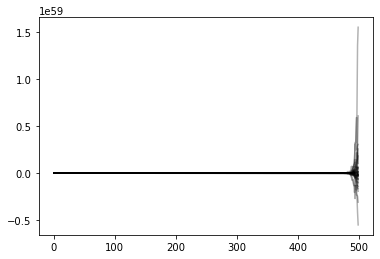

In [31]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

Text(0.5, 1.0, 'vis[:, 200]')

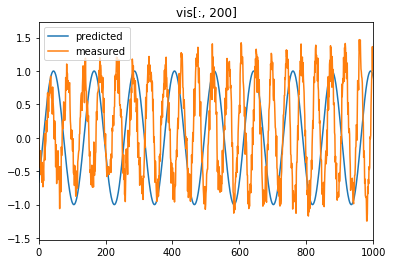

In [190]:
plt.plot(get_fringe(baseline=result.x, freq=200), label='predicted')
plt.plot(visibility[:, 200], label='measured')
plt.legend()
plt.xlim(0,1000)
plt.title('vis[:, 200]')

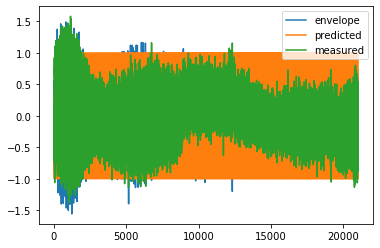

In [227]:
Y = visibility[:, 200]
y_hat = get_fringe(baseline=result.x, freq=200)
plt.plot(Y * np.conjugate(y_hat), label='envelope')
plt.plot(y_hat, label='predicted')
plt.plot(Y, label='measured')
plt.legend()
# plt.xlim(0,1000)

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


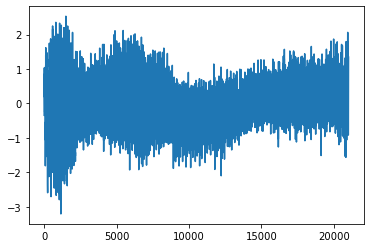

In [176]:
plt.plot(Y * np.conjugate(y_hat) - Y, label='envelope')
# plt.plot(Y, label='measured')